# Learning notebook
To use this notebook you don't need to interact with any code, just run cells in order and a graphical user interface will pop-up showcasing the parameters for each step.

In [11]:
import sys
sys.path.append('../../')
import ipywidgets as widgets
from IPython.display import display
import stackview
import datetime
import torch
import numpy as np
import imageio
import os

import ailoc.lunar
import ailoc.deeploc
import ailoc.common
import ailoc.simulation
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
ailoc.common.setup_seed(42)

%matplotlib inline

## 1. Set the necessary parameters to train the network, mainly about the training data simulation

In [2]:
learn_param_widget = ailoc.common.SetLearnParamWidget()
learn_param_widget.display_notebook_gui()

SelectFilesButton(description='Optional: select the experiment file to estimate background range', icon='squar…

SelectFilesButton(description='Select the calibration file', icon='square-o', layout=Layout(height='80px', wid…

Button(description='Load from calib', style=ButtonStyle())

Label(value='PSF parameters', style=LabelStyle(font_weight='bold'))

SetPSFParamWidget(children=(BoundedFloatText(value=1.5, description='NA:', layout=Layout(grid_area='widget001'…

Label(value='Camera parameters', style=LabelStyle(font_weight='bold'))

Dropdown(description='CameraType:', index=1, options=('Idea Camera', 'sCMOS', 'EMCCD'), value='sCMOS')

GridspecLayout(children=(sCMOSParamWidget(children=(BoundedFloatText(value=0.81, description='QE:', layout=Lay…

SetSamplerParamWidget(children=(Label(value='Sampler parameters', layout=Layout(grid_area='widget001'), style=…

Button(description='OK', style=ButtonStyle())

Output()

## Optional: using the provided experimental image to estimate the background range

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
read first (15176, 264, 268) images
experimental images provided, automatically adjust training parameters


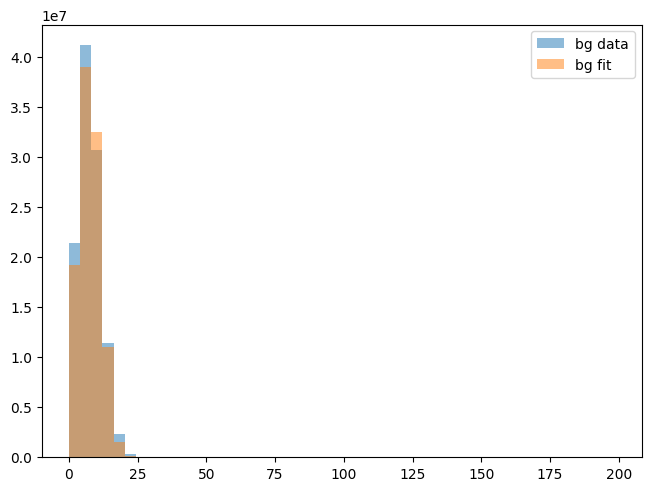

Adjusted bg_range:  (0.0, 15.500398635864258)
Check the parameters:
---------------------------------------------------------------------- learning parameters ----------------------------------------------------------------------------------------------------
na: 1.5
wavelength: 670.0
refmed: 1.406
refcov: 1.524
refimm: 1.518
objstage0: -1400.0
zemit0: 1296.7061923583663
pixel_size_xy: (108.0, 108.0)
otf_rescale_xy: (0.5, 0.5)
npupil: 64
psf_size: 27
zernike_mode:
 [[ 2.  2.  3.  3.  4.  3.  3.  4.  4.  5.  5.  6.  4.  4.  5.  5.  6.  6.
   7.  7.  8.]
 [-2.  2. -1.  1.  0. -3.  3. -2.  2. -1.  1.  0. -4.  4. -3.  3. -2.  2.
   1. -1.  0.]]
zernike_coef:
 [ 57.4   9.9 -29.7  10.4  32.2  -7.2  -7.1 -26.  -17.    9.   12.4  40.3
  -1.7   4.3   2.9  -3.   12.7  -1.1   6.1   3.1  27.1]
camera_type: scmos
qe: 0.81
spurious_charge: 0.002
read_noise_sigma: 1.6
e_per_adu: 0.47
baseline: 100.0
local_context: True
temporal_attn: True
robust_training: False
context_size: 8
train_size: 128
num_em_

In [3]:
if learn_param_widget.exp_file_receiver.files is not None:
    experimental_images = ailoc.common.read_first_size_gb_tiff(learn_param_widget.exp_file_receiver.files, 2)
    camera_calib = ailoc.simulation.instantiate_camera(learn_param_widget.params_dict['camera_params_dict'])
    experimental_images_photon = ailoc.common.cpu(camera_calib.backward(torch.tensor(experimental_images.astype(np.float32))))
    print('experimental images provided, automatically adjust training parameters')
    learn_param_widget.params_dict['sampler_params_dict']['bg_range'] = ailoc.common.get_bg_stats_gauss(experimental_images_photon, percentile=10,
                                                                      plot=True)
    print('Adjusted bg_range: ', learn_param_widget.params_dict['sampler_params_dict']['bg_range'])
    
print('Check the parameters:')
ailoc.common.print_learning_params(learn_param_widget.params_dict['psf_params_dict'], 
                                   learn_param_widget.params_dict['camera_params_dict'],
                                   learn_param_widget.params_dict['sampler_params_dict'])

## 2. Initialize the DL model

In [4]:
# loc_model = ailoc.deeploc.DeepLoc(learn_param_widget.params_dict['psf_params_dict'],
#                                   learn_param_widget.params_dict['camera_params_dict'],
#                                   learn_param_widget.params_dict['sampler_params_dict'])

# loc_model = ailoc.lunar.Lunar_LocLearning(learn_param_widget.params_dict['psf_params_dict'],
#                                   learn_param_widget.params_dict['camera_params_dict'],
#                                   learn_param_widget.params_dict['sampler_params_dict'])

loc_model = ailoc.lunar.Lunar_SyncLearning(learn_param_widget.params_dict['psf_params_dict'],
                                  learn_param_widget.params_dict['camera_params_dict'],
                                  learn_param_widget.params_dict['sampler_params_dict'])

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Testing network parameters and multiply-accumulate operations (MACs)
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.UpsamplingNearest2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
Params:1.472M, MACs:31.550G, (input shape:torch.Size([1, 14, 64, 64]))
Average forward time: 0.0100 s


## 3. Check the PSF model used for training data simulation 

checking PSF...


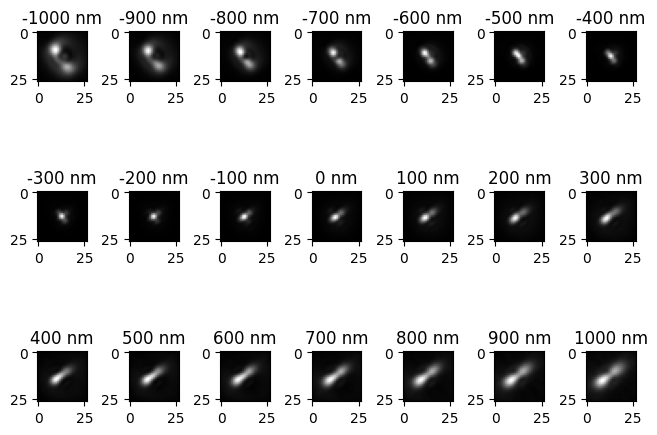

checking training data...


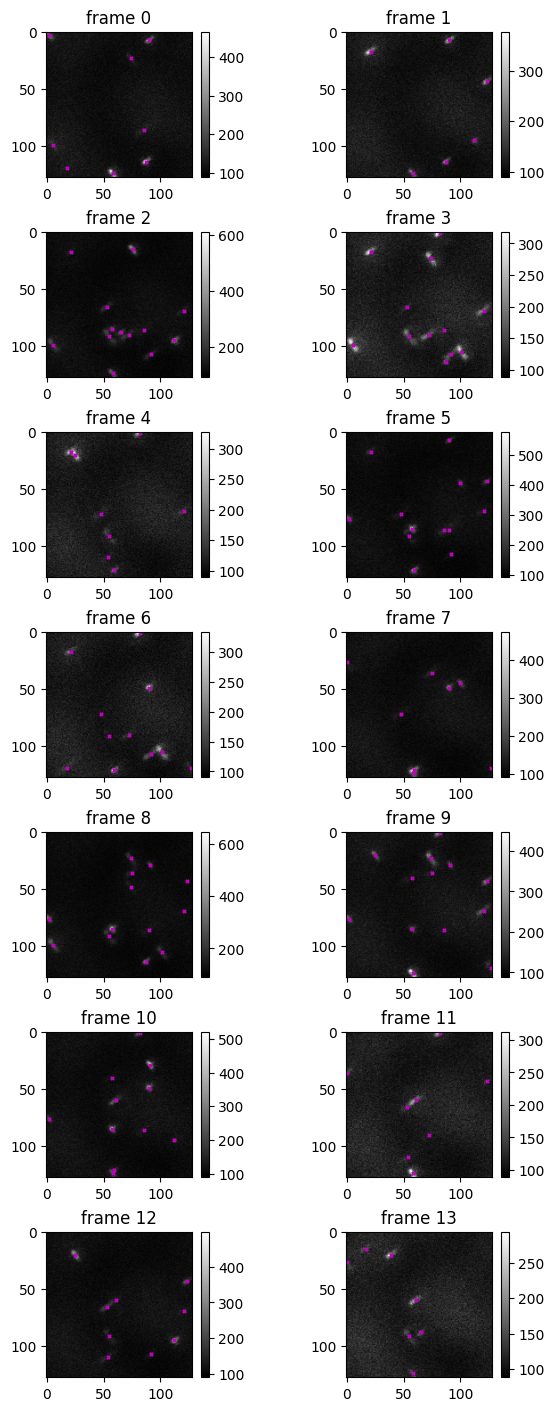

In [5]:
loc_model.check_training_psf()
loc_model.check_training_data()

## 4. Simulate an evaluation dataset to track the network performance

In [6]:
loc_model.build_evaluation_dataset(napari_plot=False)
display(stackview.slice(loc_model.evaluation_dataset['data'][:,0], colormap='turbo', continuous_update=True))

building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 7967 target molecules, time cost: 13.06s


## 5. Your are ready to go training the network!

In [7]:
# file_name = '../../results/' + datetime.datetime.now().strftime('%Y-%m-%d-%H') + 'DeepLoc.pt'
# loc_model.online_train(
#         batch_size=2,
#         max_iterations=40000,
#         eval_freq=500,
#         file_name=file_name
#     )

# file_name = '../../results/' + datetime.datetime.now().strftime('%Y-%m-%d-%H') + 'LUNAR_LL.pt'
# loc_model.online_train(
#         batch_size=2,
#         max_iterations=40000,
#         eval_freq=500,
#         file_name=file_name
#     )

file_name = '../../results/' + datetime.datetime.now().strftime('%Y-%m-%d-%H') + 'LUNAR_SL.pt'
loc_model.online_train(
        batch_size=1,
        max_iterations=40000,
        eval_freq=1000,
        file_name=file_name,
        real_data=experimental_images,
        num_sample=100,
        wake_interval=2,
        max_recon_psfs=5000,
        online_build_eval_set=True,
    )

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Start training...
Iterations: 1000/40000 || Loss_sleep: 462.09 || Loss_wake: nan || IterTime: 160.12 ms || ETA: 1.73 h || No record found
LUNAR instance saved to ../../results/2024-12-30-07LUNAR_SL.pt
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8323 target molecules, time cost: 11.76s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7186, predictions: 3910, please waiting...
evaluating done! time cost: 3.76s


100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:53<00:00,  6.23it/s]



Estimation done, the z distribution of 116018 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.00575814 0.52966263 0.16955005 0.0544563  0.0610432  0.05266066
 0.03308989 0.0347992  0.04023792 0.01874201]
The corresponding z weight is:
[0.46640456 0.00507044 0.01583971 0.04931703 0.04399545 0.05099866
 0.08116145 0.07717485 0.06674358 0.14329426]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8043 target molecules, time cost: 11.34s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 6983, predictions: 6348, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:54<00:00,  6.22it/s]



Estimation done, the z distribution of 130234 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.02416998 0.36939806 0.31808121 0.06766668 0.05275903 0.04860217
 0.02853507 0.03385648 0.03598504 0.02094628]
The corresponding z weight is:
[0.17121751 0.01120288 0.01301027 0.06115747 0.07843819 0.08514688
 0.14502586 0.12223136 0.11500121 0.19756836]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8106 target molecules, time cost: 11.32s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7059, predictions: 6575, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.19it/s]



Estimation done, the z distribution of 168478 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.1188153  0.29826462 0.26392618 0.05919333 0.05399018 0.05219824
 0.04344694 0.04075606 0.04349457 0.02591457]
The corresponding z weight is:
[0.04694988 0.01870274 0.02113608 0.09423974 0.10332184 0.10686881
 0.12839487 0.13687201 0.12825428 0.21525976]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8199 target molecules, time cost: 11.31s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7163, predictions: 6777, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:54<00:00,  6.22it/s]



Estimation done, the z distribution of 147090 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.08538244 0.3387281  0.26342346 0.07471983 0.05346943 0.04722691
 0.04086878 0.03799233 0.03790393 0.02028479]
The corresponding z weight is:
[0.0590947  0.01489587 0.01915414 0.06752758 0.09436513 0.10683845
 0.12345974 0.13280706 0.1331168  0.24874054]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8087 target molecules, time cost: 11.47s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7115, predictions: 6744, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:54<00:00,  6.22it/s]



Estimation done, the z distribution of 172407 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.12933028 0.31794908 0.24426076 0.06705346 0.05767494 0.05427887
 0.03857423 0.03138016 0.0338209  0.02567732]
The corresponding z weight is:
[0.04028198 0.01638526 0.02132835 0.07769442 0.0903283  0.09597987
 0.13505595 0.16601828 0.15403728 0.20289031]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8097 target molecules, time cost: 11.39s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7093, predictions: 6601, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:54<00:00,  6.21it/s]



Estimation done, the z distribution of 179216 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.14481592 0.23368658 0.30315916 0.07000273 0.05841746 0.04997963
 0.03863432 0.03408057 0.04535333 0.02187027]
The corresponding z weight is:
[0.03655661 0.02265418 0.0174627  0.07562532 0.09062323 0.10592273
 0.13702787 0.15533715 0.11672745 0.24206276]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8113 target molecules, time cost: 11.45s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7155, predictions: 6876, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.19it/s]



Estimation done, the z distribution of 195656 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.15526655 0.27318365 0.26070486 0.06528741 0.05783388 0.04720058
 0.04057522 0.03125575 0.04294215 0.02574995]
The corresponding z weight is:
[0.03453507 0.01962834 0.02056786 0.08213132 0.09271627 0.11360329
 0.1321531  0.17155694 0.12486895 0.20823886]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8160 target molecules, time cost: 11.56s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7167, predictions: 6996, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:54<00:00,  6.20it/s]



Estimation done, the z distribution of 184758 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.12502165 0.29524098 0.24213506 0.07063288 0.0617882  0.05055103
 0.04360629 0.03866431 0.05214242 0.02021717]
The corresponding z weight is:
[0.04368992 0.01850077 0.02255842 0.07733206 0.08840175 0.1080529
 0.12526142 0.14127201 0.10475511 0.27017564]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8190 target molecules, time cost: 11.57s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7207, predictions: 6966, please waiting...
evaluating done! time cost

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.19it/s]



Estimation done, the z distribution of 190937 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.13366752 0.27375677 0.25715767 0.06467834 0.06670019 0.05454288
 0.04895398 0.03484815 0.0447479  0.0209466 ]
The corresponding z weight is:
[0.04087629 0.01995871 0.02124701 0.08447701 0.0819163  0.10017499
 0.11161162 0.15678974 0.12210256 0.26084575]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8284 target molecules, time cost: 11.45s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7260, predictions: 7002, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.16it/s]



Estimation done, the z distribution of 207187 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.19366371 0.23532111 0.2587996  0.06379772 0.05621793 0.04340139
 0.03832404 0.03421772 0.04198591 0.03427086]
The corresponding z weight is:
[0.02899346 0.02386093 0.02169625 0.08801224 0.09987881 0.12937329
 0.14651326 0.16409568 0.13373486 0.16384123]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8222 target molecules, time cost: 11.61s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7235, predictions: 7023, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:54<00:00,  6.20it/s]



Estimation done, the z distribution of 186109 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.12831014 0.28970692 0.24902046 0.06975282 0.07247779 0.05489178
 0.04079395 0.03272653 0.04144429 0.02087532]
The corresponding z weight is:
[0.04129848 0.01829095 0.02127943 0.07596845 0.07311224 0.09653565
 0.12989705 0.16191798 0.12785872 0.25384104]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8381 target molecules, time cost: 11.64s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7261, predictions: 7009, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:54<00:00,  6.21it/s]



Estimation done, the z distribution of 190049 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.13457804 0.22630518 0.28133831 0.06553141 0.07101473 0.04625561
 0.04617141 0.04307192 0.0538228  0.03191058]
The corresponding z weight is:
[0.0461081  0.02741933 0.02205579 0.09468951 0.08737818 0.13414886
 0.13439349 0.14406457 0.11528828 0.1944539 ]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8213 target molecules, time cost: 11.47s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7168, predictions: 6886, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:54<00:00,  6.20it/s]



Estimation done, the z distribution of 185152 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.13224886 0.26986785 0.2557402  0.06601368 0.05882289 0.05061103
 0.04638624 0.04013009 0.05197247 0.02820668]
The corresponding z weight is:
[0.04494074 0.02202323 0.02323984 0.09003227 0.10103823 0.11743214
 0.12812768 0.14810235 0.11435595 0.21070758]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8026 target molecules, time cost: 11.24s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7028, predictions: 6855, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:56<00:00,  6.14it/s]



Estimation done, the z distribution of 183848 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.1235919  0.25071935 0.29346141 0.07621555 0.05966918 0.04710983
 0.04252993 0.03557306 0.04859476 0.02253504]
The corresponding z weight is:
[0.04417246 0.02177478 0.01860333 0.0716305  0.09149377 0.11588576
 0.12836509 0.1534689  0.11234459 0.24226083]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 7986 target molecules, time cost: 11.45s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7005, predictions: 6776, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.18it/s]



Estimation done, the z distribution of 194939 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.13269379 0.20431437 0.31740112 0.06783461 0.06335608 0.05792336
 0.04787873 0.03739291 0.04639101 0.02481404]
The corresponding z weight is:
[0.04359791 0.02831505 0.01822669 0.08528349 0.09131203 0.09987633
 0.1208297  0.15471308 0.12470459 0.23314112]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8081 target molecules, time cost: 11.43s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7087, predictions: 6963, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.18it/s]



Estimation done, the z distribution of 196729 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.13831984 0.23399992 0.28923224 0.06500224 0.06326288 0.0518248
 0.0427313  0.0355806  0.04429775 0.03574843]
The corresponding z weight is:
[0.04316127 0.02551309 0.02064106 0.09184392 0.09436909 0.11519697
 0.13971163 0.16778976 0.1347712  0.16700201]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8094 target molecules, time cost: 11.53s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7121, predictions: 6938, please waiting...
evaluating done! time cost

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.19it/s]



Estimation done, the z distribution of 199994 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.13552685 0.20522823 0.31343866 0.07791331 0.06580046 0.05061689
 0.04074457 0.03478818 0.04474552 0.03119733]
The corresponding z weight is:
[0.04316964 0.02850799 0.018666   0.07509173 0.08891496 0.11558681
 0.14359323 0.16817914 0.13075378 0.18753672]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8259 target molecules, time cost: 11.34s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7305, predictions: 7092, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.17it/s]



Estimation done, the z distribution of 195701 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.13492615 0.22639648 0.28372259 0.0666326  0.0740277  0.05861399
 0.04630756 0.03794654 0.05107579 0.02035059]
The corresponding z weight is:
[0.04173239 0.02487137 0.01984611 0.08450505 0.0760633  0.09606565
 0.12159551 0.14838746 0.11024383 0.27668932]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8257 target molecules, time cost: 11.34s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7248, predictions: 7093, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.19it/s]



Estimation done, the z distribution of 190839 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.11632282 0.18262756 0.34559375 0.07254587 0.06626806 0.05559369
 0.04855605 0.03835855 0.04718311 0.02695055]
The corresponding z weight is:
[0.05093118 0.03244011 0.01714284 0.081665   0.08940141 0.10656709
 0.12201276 0.15444949 0.12556311 0.219827  ]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8073 target molecules, time cost: 11.40s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7001, predictions: 6853, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:56<00:00,  6.14it/s]



Estimation done, the z distribution of 197899 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.14059365 0.22244404 0.28760595 0.06165945 0.06953366 0.05495272
 0.04826115 0.0371018  0.04570886 0.03213872]
The corresponding z weight is:
[0.04322554 0.0273203  0.02113043 0.09856132 0.08739992 0.11059028
 0.12592399 0.16379896 0.13295535 0.18909391]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8107 target molecules, time cost: 11.34s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7179, predictions: 7039, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.19it/s]



Estimation done, the z distribution of 192900 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.12441474 0.22044664 0.30372855 0.06482322 0.06433064 0.05591534
 0.04839186 0.04052099 0.04892592 0.0285021 ]
The corresponding z weight is:
[0.04853962 0.02739458 0.01988303 0.09316174 0.09387508 0.10800334
 0.12479461 0.14903494 0.12343239 0.21188067]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8153 target molecules, time cost: 11.41s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7056, predictions: 6938, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:56<00:00,  6.15it/s]



Estimation done, the z distribution of 204555 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.15564822 0.17598545 0.32365034 0.07029543 0.07212382 0.05293545
 0.04659474 0.03565859 0.04116822 0.02593974]
The corresponding z weight is:
[0.03681268 0.03255854 0.01770376 0.08151069 0.07944433 0.10824179
 0.12297158 0.16068579 0.13918088 0.22088996]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8169 target molecules, time cost: 11.50s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7160, predictions: 6994, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.18it/s]



Estimation done, the z distribution of 198789 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.13429877 0.19981282 0.30825819 0.07128552 0.07132075 0.05901799
 0.04976451 0.03885054 0.04575417 0.02163674]
The corresponding z weight is:
[0.04264752 0.02866437 0.01858023 0.08034603 0.08030635 0.09704683
 0.11509224 0.1474242  0.12518006 0.26471215]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8378 target molecules, time cost: 11.60s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7208, predictions: 7063, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:56<00:00,  6.15it/s]



Estimation done, the z distribution of 206745 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.17889156 0.17054222 0.31980476 0.06716718 0.06358267 0.05238895
 0.04884314 0.03709795 0.04225461 0.01942696]
The corresponding z weight is:
[0.0299162  0.03138082 0.01673444 0.07967813 0.08417003 0.10215428
 0.10957025 0.14426012 0.12665493 0.27548079]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8023 target molecules, time cost: 11.40s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 6967, predictions: 6822, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.18it/s]



Estimation done, the z distribution of 198486 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.15557605 0.18599085 0.32556335 0.06745576 0.06168118 0.05537751
 0.04804088 0.03474322 0.0430826  0.02248861]
The corresponding z weight is:
[0.03546387 0.02966452 0.01694702 0.08179182 0.08944915 0.09963122
 0.11484656 0.15880306 0.12806398 0.2453388 ]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8332 target molecules, time cost: 11.63s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7283, predictions: 7152, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.17it/s]



Estimation done, the z distribution of 199428 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.15072817 0.18345829 0.32725603 0.06963556 0.06441641 0.05366194
 0.04683187 0.03541497 0.04187869 0.02671806]
The corresponding z weight is:
[0.03800749 0.03122671 0.01750556 0.0822683  0.08893385 0.10675722
 0.12232693 0.16176207 0.13679508 0.21441678]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8052 target molecules, time cost: 11.54s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7037, predictions: 6904, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.17it/s]



Estimation done, the z distribution of 199942 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.14334092 0.16207888 0.34111497 0.07366131 0.06694345 0.05188205
 0.04571943 0.03522497 0.04384864 0.03618538]
The corresponding z weight is:
[0.0423919  0.03749097 0.01781362 0.08249235 0.09077055 0.11712132
 0.13290835 0.1725053  0.13857886 0.16792678]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8212 target molecules, time cost: 11.41s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7083, predictions: 6934, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.16it/s]



Estimation done, the z distribution of 200250 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.14275508 0.17590071 0.3266649  0.06946394 0.06352331 0.0536006
 0.05017812 0.03921118 0.04755505 0.03114711]
The corresponding z weight is:
[0.04294601 0.03485353 0.01876774 0.08825817 0.09651198 0.11437858
 0.12217996 0.15635236 0.12891924 0.19683243]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8259 target molecules, time cost: 11.36s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7241, predictions: 7114, please waiting...
evaluating done! time cost

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.17it/s]



Estimation done, the z distribution of 201918 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.14614116 0.16886179 0.33719853 0.07345693 0.06814703 0.05474845
 0.04386612 0.03400912 0.04120127 0.03236959]
The corresponding z weight is:
[0.04033468 0.03490758 0.01748097 0.08024507 0.08649763 0.10766619
 0.13437606 0.1733228  0.14306737 0.18210166]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8090 target molecules, time cost: 11.27s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7115, predictions: 6994, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.18it/s]



Estimation done, the z distribution of 198601 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.14101131 0.182362   0.32879644 0.07025388 0.06553068 0.05505705
 0.04678389 0.03680373 0.04601347 0.02738753]
The corresponding z weight is:
[0.04169941 0.03224404 0.01788367 0.08369769 0.08973031 0.10679991
 0.12568617 0.15976881 0.12779057 0.21469943]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8336 target molecules, time cost: 11.58s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7296, predictions: 7160, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.16it/s]



Estimation done, the z distribution of 210043 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.15709184 0.16891396 0.32376803 0.06852831 0.06451935 0.05541589
 0.04827882 0.03703757 0.04523163 0.03121459]
The corresponding z weight is:
[0.03849394 0.03579979 0.01867721 0.08824213 0.09372512 0.10912183
 0.12525336 0.16326893 0.13369148 0.19372621]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8242 target molecules, time cost: 11.58s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7174, predictions: 7032, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.18it/s]



Estimation done, the z distribution of 197366 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.15107294 0.17449267 0.3329077  0.06998049 0.06389501 0.05305667
 0.04471131 0.03602138 0.04404246 0.02981936]
The corresponding z weight is:
[0.03882075 0.03361038 0.01761679 0.08380571 0.09178753 0.11053774
 0.13116962 0.16281344 0.13316161 0.19667642]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8214 target molecules, time cost: 11.36s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7225, predictions: 7084, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.17it/s]



Estimation done, the z distribution of 206340 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.15152382 0.17458948 0.32154766 0.07055408 0.06492216 0.05339175
 0.04677594 0.03697582 0.04650453 0.03321475]
The corresponding z weight is:
[0.0402964  0.03497269 0.01898899 0.08654162 0.094049   0.11435969
 0.13053429 0.16513126 0.13129613 0.18382991]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8138 target molecules, time cost: 11.74s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7138, predictions: 6998, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.17it/s]



Estimation done, the z distribution of 202595 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.15087867 0.1697058  0.33114325 0.07034258 0.06441899 0.05355415
 0.04679633 0.036667   0.04537467 0.03111857]
The corresponding z weight is:
[0.03974289 0.03533382 0.01810804 0.08524501 0.09308364 0.11196806
 0.12813728 0.16353547 0.13215203 0.19269376]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8201 target molecules, time cost: 11.51s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7118, predictions: 7006, please waiting...
evaluating done! time cos

100%|██████████████████████████████████████████████████████████████████████████████| 1084/1084 [02:55<00:00,  6.18it/s]



Estimation done, the z distribution of 205322 molecules in real data is:
[-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
[0.15188739 0.16850616 0.32844966 0.0708928  0.06492621 0.0534314
 0.04719692 0.03720715 0.04648093 0.03102138]
The corresponding z weight is:
[0.0397572  0.03583618 0.01838521 0.08517956 0.09300739 0.11301627
 0.12794514 0.16229722 0.12991601 0.19465983]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 8175 target molecules, time cost: 11.17s
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 7135, predictions: 7026, please waiting...
evaluating done! time cost

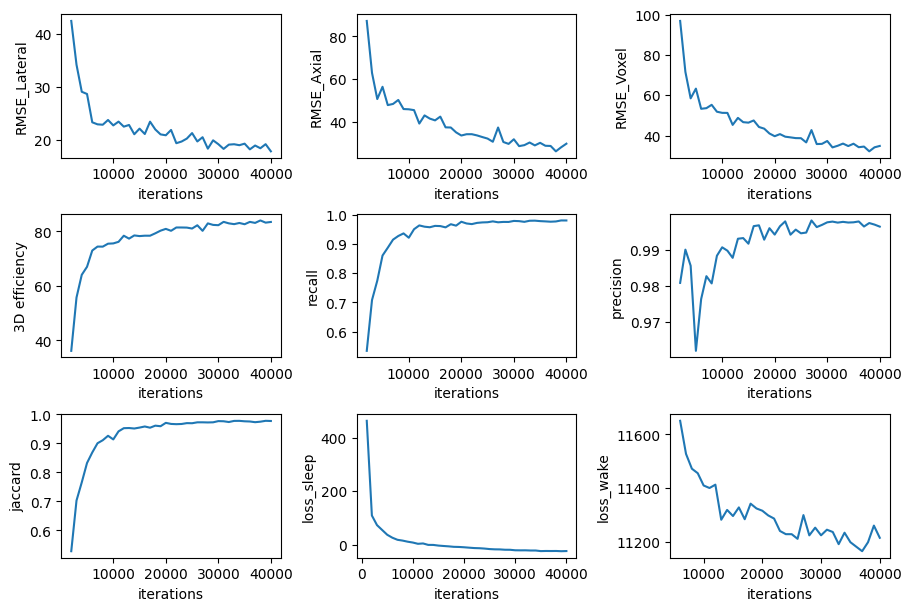

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Plot the phase learning process, this may take a while


In [13]:
# # plot evaluation performance during the localization learning
# ailoc.common.plot_train_record(loc_model)

# plot evaluation performance during the synchronized learning
phase_record = ailoc.common.plot_synclearning_record(loc_model)
# save the pupil changes during the learning
imageio.mimsave('../../results/' + os.path.split(file_name)[-1].split('.')[0] + '_phase.gif',
                phase_record,
                duration=200)

In [ ]:
# test single emitter localization accuracy with CRLB
_,_,_, = ailoc.common.test_single_emitter_accuracy(
    loc_model=loc_model,
    psf_params=None,
    xy_range=(-50, 50),
    z_range=np.array(loc_model.dict_sampler_params['z_range']) * 0.98,
    photon=np.mean(loc_model.dict_sampler_params['photon_range']),
    bg=np.mean(loc_model.dict_sampler_params['bg_range']),
    num_z_step=31,
    num_repeat=1000,
    show_res=True
)